# Azimuthal Integral

## Introduction

This tutorial demonstrates how to acquire an azimuthal integral profile from a multidimensional data set in pyXem. 

The data set is a 10x10x256x256 data set of a polycrystalline gold film acquired using a Medipix3 256 by 256 pixel detector. 

This functionality has been checked to run in pyxem-0.13.2 (May 2021). Bugs are always possible, do not trust the code blindly, and if you experience any issues please report them here: https://github.com/pyxem/pyxem-demos/issues

## Contents

At this point things are mostly set up.  There are a couple of different work flows moving forward which allow the user a fair degree of control.  In general the key parameter is the unit keyword in the integration.  Let's show the different use cases and you can choose which works the best into your workflow. Case 1 and Case 2 should be suffient for most use cases but case 3 gives you additional functionality by allowing to user to predefine their detector to thier specifications.  

0. <a href='#c0'> Loading and Inspection</a>
1. <a href='#c1'> PyXEM units based integration</a>
3. <a href='#c2'> PyFAI units based integration</a>
4. <a href='#c3'> Additional Parameters (center, affine, masks, methods)</a>

<a id='c0'></a> 

## 0. Loading and Inspection

Import pyxem and other required libraries

In [1]:
%matplotlib inline
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt

Assert that pyxem is properly loaded into hyperspy..

In [2]:
print(hs.print_known_signal_types())

+----------------------------+---------------------+----------------------------+----------+
|        signal_type         |       aliases       |         class name         | package  |
+----------------------------+---------------------+----------------------------+----------+
|        correlation         |                     |       Correlation2D        |  pyxem   |
|     CorrelationSignal      |                     |     CorrelationSignal      |  empyer  |
|            dpc             |                     |       DPCBaseSignal        |  pyxem   |
|            dpc             |                     |        DPCSignal1D         |  pyxem   |
|            dpc             |                     |        DPCSignal2D         |  pyxem   |
|     DielectricFunction     | dielectric function |     DielectricFunction     | hyperspy |
|        diffraction         |                     |       Diffraction1D        |  pyxem   |
|        diffraction         |                     |       Diffraction

Load polycrystalline SED data

In [3]:
dp = hs.load("./data/07/azimuthal_integration.hspy", signal_type='electron_diffraction')

ERROR:numba.cuda.cudadrv.driver:Call to cuInit results in CUDA_ERROR_NO_DEVICE


Check the data size and type.  It is also a good idea to look at your data as well just to make sure it loaded properly. Then we will set the diffraction and scan calibration based on values found by calibrating the dataset to a known standard.

In [4]:
calib = 0.009197
dp.diffraction_calibration=calib
dp.scan_calibration= 5
dp.axes_manager

<Axes manager, axes: (10, 10|256, 256)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
     <undefined> |     10 |      0 |     4.5 |       5 | <undefined> 
     <undefined> |     10 |      0 |     4.5 |       5 | <undefined> 
---------------- | ------ | ------ | ------- | ------- | ------ 
     <undefined> |    256 |        |       0 |  0.0092 | <undefined> 
     <undefined> |    256 |        |       0 |  0.0092 | <undefined>

Signal type and dimensions:  <ElectronDiffraction2D, title: , dimensions: (10, 10|256, 256)>


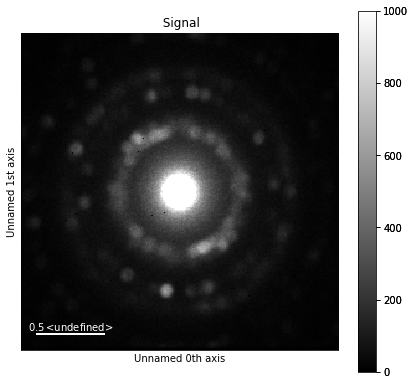

In [5]:
print("Signal type and dimensions: ", dp)
dp.inav[1,1].plot(vmax=1000)
plt.show()

<a id='c1'></a>

## Case 1: PyXEM units based integration.

The key difference between Case 1 and Case 2 is that for Case 1 the units are already set in PyXEM so the detector distance and dectector set up are just handled by creating a generic set up that aligns with how pyXEM deals with calibrations.  

All of these integrations are done by pyFAI so it might be worth it to discuss how pyFAI does their integration.

**PyFAI Integration**
In pyFAI there are three geometries that are of interest.  The best way to think about them are as two concentric spheres with a real detector at the apex of one sphere and an imaginary detector at the apex of the other sphere. This gives rise to two corrections that are applied to the data. 

1- correctSolidAngle: This is to correct for a sphere being projected onto a flat detector.  It takes and makes pixel values farther from the center more intense to account for their lower intensity.
2- Ewald Sphere Correction: This takes into account the change in intensity for dealing with the ewald sphere as well as the distorition in the spacing.  

What connects these two spheres is that their solid angles are equal, which gives rise to the 2th_deg and 2th_rad formalisim.  By their nature these two ignore the ewald 


To simplify things when pyXEM deals with this integration we assume a flat detector and constant radius of one sphere and then just change the pixel size of the detector to

The key things that need to be set are the "unit" and the "beam_energy" which are both attribuites that can be set with:
 
    dp.unit = "k_A^-1"
    dp.beam_energy =  200 # keV

The other acceptable units are "k_nm^-1", "q_nm^-1", "q_A^-1", "2th_deg", "2th_rad". 
 - "q_nm^-1" (q inverse spacing, mostly used with Xray data)
 - "q_A^-1"
 - "k_nm^-1" (k inverse spacing, mostly used for electron diffraction data, factor of 2 pi less than q)
 - "k_A^-1"
 - "2th_deg" (degree spacing, doesn't account for ewald sphere)
 - "2th_rad" (radial spacing, doesn't account for ewald sphere)
 
 **Note:**
 
For electron diffraction the Ewald sphere is largely not considered.  Rather some reflection in a standard material is used to calibrate the pixel size.  Then that pixel size is used consistantly assuming a constant.  This is mostly correct, and largely what we do in the first case expect we use that calibration to define one point on the Ewald sphere and then calculate the scale from there. 

In [6]:
dp.unit = "k_A^-1" 
dp.beam_energy = 200 # in 200 keV

In [7]:
dp.axes_manager # see how the units now are set for the signal axis.

<Axes manager, axes: (10, 10|256, 256)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
     <undefined> |     10 |      0 |     4.5 |       5 | <undefined> 
     <undefined> |     10 |      0 |     4.5 |       5 | <undefined> 
---------------- | ------ | ------ | ------- | ------- | ------ 
     <undefined> |    256 |        |       0 |  0.0092 | k_A^-1 
     <undefined> |    256 |        |       0 |  0.0092 | k_A^-1

In [8]:
#if we want to see more about the function 
dp.set_ai?

In [9]:
dp.set_ai()

In [10]:
integration  = dp.get_azimuthal_integral1d(npt=100, )

[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.3s


In [11]:
integration2d = dp.get_azimuthal_integral2d(npt=100)

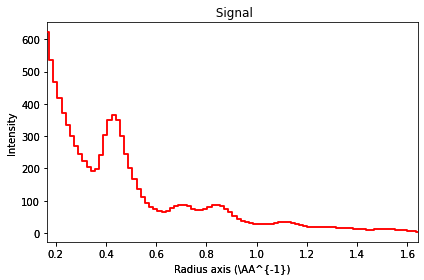

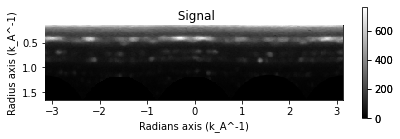

In [12]:
# Excluding the zero beam...
integration.inav[0,0].isig[10:].plot()
integration2d.inav[0,0].isig[:,10:].plot()
plt.show()

<a id='c2'></a>

## Case 2: PyFAI based Integration

The second case involves setting up your own detector, detector distance, wavelength etc.  If you have a good understanding of [pyFAI](https://pyfai.readthedocs.io/en/latest/index.html) then this might actually be the best route.  There are a significant number of parameters to play with when using pyFAI, however, so there is a litte bit of extra set up involved and in my opinion a little more difficulty in getting more advanced cases. There are a couple of detectors already set up in pyxem dectectors and more in pyFAI so check there first to see what other people have done.

In [13]:
from pyxem.detectors import Medipix256x256Detector

In [14]:
detector = Medipix256x256Detector()
print(detector)

Detector Medipix256x256Detector	 Spline= None	 PixelSize= 5.500e-05, 5.500e-05 m


**Calibration:**

In addition to specifying the detector, to accurately calculate the curvature of the Ewald Sphere, it is important to specify a calibration. In addition, the wavelength is specified to do that calculation.

The calibration is calculated by knowing the camera length. Alternatively, by assuming a no curvature in the detector, it is possible to calculate the camera length from an "inverse angstroms per pixel" calibration value. We suggest calibrating to a gold pattern for a calibration value and using the latter (for electron microscopy).

In [15]:
# Reading the camera length from microscope
camera_length = 0.24 #in metres

In [16]:
# Calculating camera length from real pixel size and recoporical pixel size
wavelength = 2.5079e-12
pix_size = 55e-6 #change to 1 if using the GenericFlatDetector()
camera_length = pix_size / (wavelength * calib * 1e10)
print('Camera Length:', camera_length)

Camera Length: 0.2384549199868201


In [17]:
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator

In [18]:
center=(128,128)
ai = AzimuthalIntegrator(dist=camera_length, detector=detector, wavelength=wavelength)
ai.setFit2D(directDist=camera_length*1000, centerX=center[1], centerY=center[0])
dp.metadata.set_item("Signal.ai", ai)

In [19]:
integration1d = dp.get_azimuthal_integral1d(npt =100)
integration2d = dp.get_azimuthal_integral2d(npt =100)

[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.2s


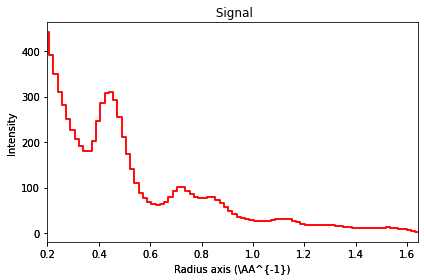

In [20]:
integration1d.inav[1,1].isig[0.2:].plot()

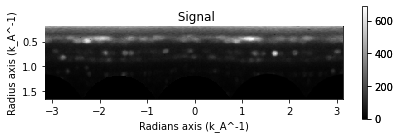

In [21]:
integration2d.inav[1,1].isig[:, 0.2:].plot()

<a id='c3'></a>

##  **Additional Parameters:**

There are a couple of different thing you can play around with at this point.  For one there are three additional parameters that are useful for more advanced calibrations.  These will work in all three of the cases but with case 3 some of these parameters can be intialized as you instantiate the detector.  For the most part though these should be passed in as the method is calls.

The three parameters are:

- center - The center of the diffraction pattern if it is not the center of the image
- affine - A 3x3 matrix which represents an affine transformation to the singal.
- mask - A mask with the same size as the singal.  

These three parameters can also be passed as BaseSignal objects from hyperspy and with the same size navigation axes as the original signal.  In this case they will be iterated with the diffraction signal and a different calibration is applied to every diffraciton pattern

### Affine

This applies an affine transfromation to the dataset before the integration. 

In [22]:
affine = np.array([[0.99978285, 0.00341758, 0.],
                   [0.00341758, 0.94621262, 0.],
                   [0., 0., 1.]])

In [23]:
dp.set_ai(affine=affine)

In [24]:
integration  = dp.get_azimuthal_integral1d(npt=100)
integration2d = dp.get_azimuthal_integral2d(npt=100)

[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.2s


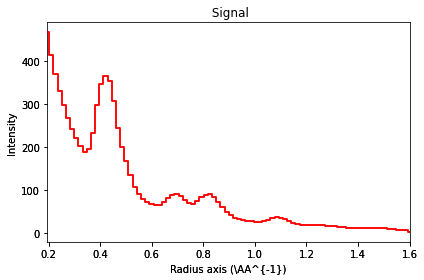

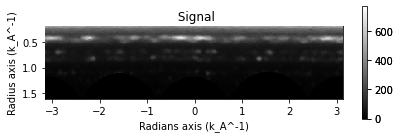

In [25]:
# Excluding the zero beam...
integration.inav[0,0].isig[0.2:].plot()
integration2d.inav[0,0].isig[:,.2:].plot()
plt.show()

Let's take a different example using an obviously distorted ring pattern.  The goal is to apply an affine transformation such that the rings become lines with minimal distortion.  In general just appling a azimuthal integration2d to your diffraction image is a good way to determine if there is any distortion in the image.  Waves in the image are much more obvious than slight ellipticity in an image with cartesian coodinates. 

In [26]:
from diffsims.utils.ring_pattern_utils import generate_ring_pattern

In [27]:
 x0 = [95, 1200, 2.8, 450, 1.5, 10]
ring_data = generate_ring_pattern(
        image_size=256,
        mask=True,
        mask_radius=10,
        scale=x0[0],
        amplitude=x0[1],
        spread=x0[2],
        direct_beam_amplitude=x0[3],
        asymmetry=x0[4],
        rotation=x0[5],
    )

In [28]:
import pyxem
import numpy as np

In [29]:
d =pyxem.signals.ElectronDiffraction2D(data=ring_data)

In [30]:
a = np.asarray(
        [[1.06651526, 0.10258988, 0.0], [0.10258988, 1.15822961, 0.0], [0.0, 0.0, 1.0]]
    )

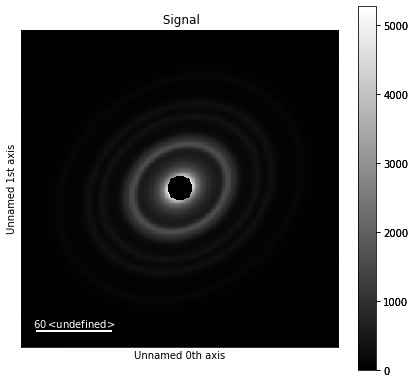

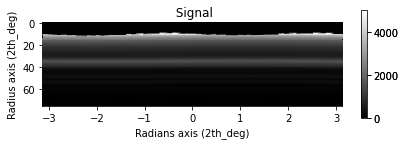

In [31]:
d.plot()
d.unit = "2th_deg"
d.set_ai(affine=a)
d.get_azimuthal_integral2d(npt=100, correctSolidAngle=False).plot()

### Masking

Below we show how a mask might be applied.  For the time being it is much faster to have mask, center and affine be numpy arrays rather than BaseSignals as making a new integration object for each is quite a costly computation.

In [32]:
mask = dp.get_direct_beam_mask(radius=30)

In [33]:
integration  = dp.get_azimuthal_integral1d(npt=100, mask=mask.data)
integration2d = dp.get_azimuthal_integral2d(npt=100, mask=mask.data)

[########################################] | 100% Completed |  0.2s


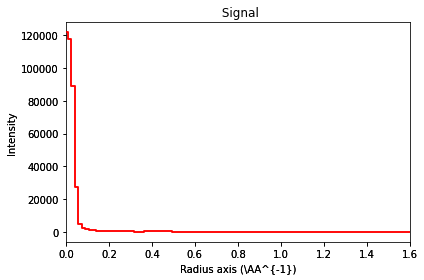

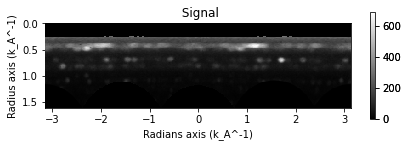

In [34]:
integration.inav[1,1].isig[:].plot()
integration2d.inav[1,1].isig[:,:].plot()

### Methods

This final section gives a breif explination of the different methods avaible through pyfai. They all also have the option to correctSolidAngle.  It is best just to show you the output for each method and from there you can determine which you might perfer. The correctSolid angle parameter is largely unimportant in electron microcopy becuase of the size of the Ewald's Sphere

In [35]:
methods = ["numpy", "cython", "BBox","splitpixel", "lut", "csr", "nosplit_csr", "full_csr"]

In [36]:
littledp = dp.inav[1,1]

In [37]:
import time

In [38]:
integrations= [] 
times = [] 
for method in methods:
    tic = time.time()
    no_sa = littledp.get_azimuthal_integral2d(npt=100, method=method, correctSolidAngle=False)
    toc = time.time()
    sa = littledp.get_azimuthal_integral2d(npt=100, method=method, correctSolidAngle=True)
    toc2 =time.time()
    integrations.append(no_sa)
    integrations.append(sa)
    times.append([toc-tic, toc2-toc])

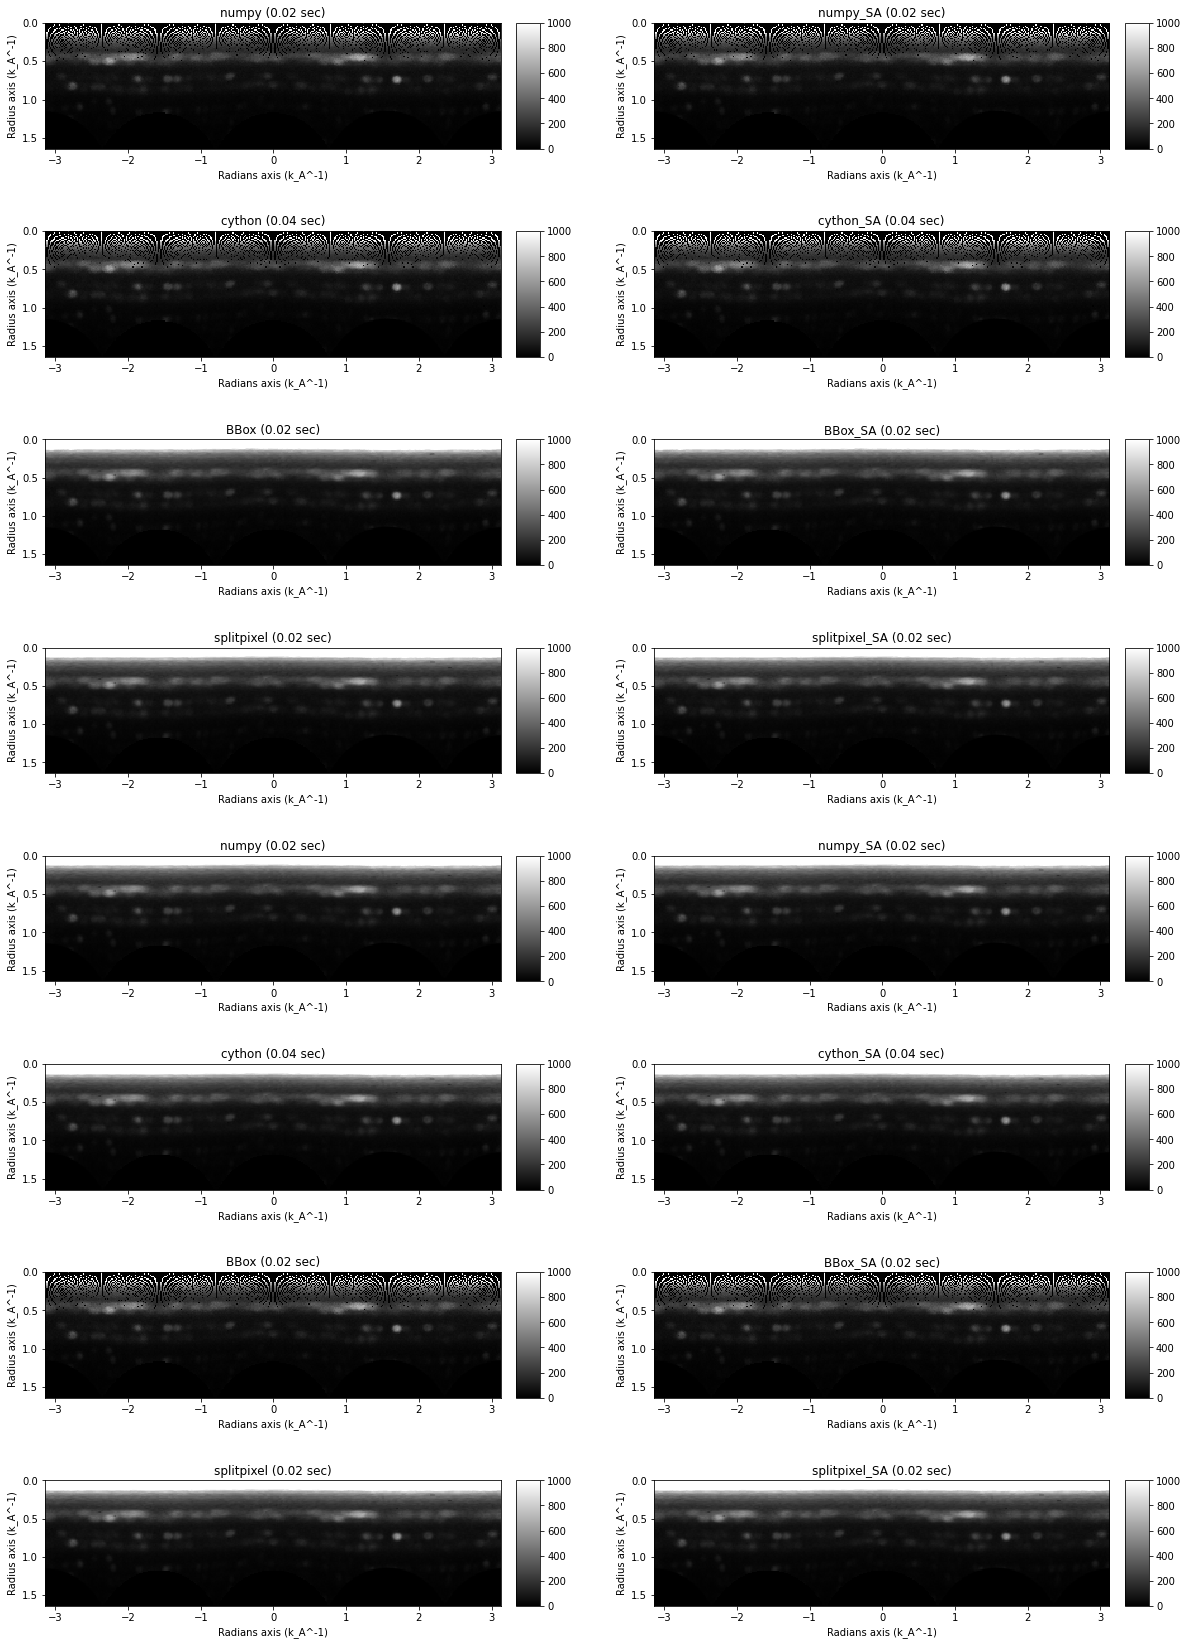

In [39]:
lab = ["numpy","numpy_SA", "cython","cython_SA", "BBox", "BBox_SA", "splitpixel","splitpixel_SA",
           "lut","lut_SA", "csr","csr_SA", "nosplit_csr","nosplit_csr_SA", "full_csr","full_csr_SA"]
lab_time = [ l+" ("+str(round(t[0],2))+" sec)" for l,t in zip(lab,times)]
f = plt.figure(figsize=(20,30))
hs.plot.plot_images(integrations,vmax=(1000), per_row=2, fig=f, label=lab_time)
plt.show()